In [22]:
import numpy as np
import math
import scipy
from scipy.optimize import root, minimize

import matplotlib.pyplot as plt
from sympy import *
init_printing()

from sympy.plotting import plot3d_parametric_line

from mpl_toolkits.mplot3d import Axes3D 

%matplotlib notebook

from jplephem.spk import SPK
from jdcal import gcal2jd, jd2gcal

Блок программ для работы с эфемеридами:

In [23]:
def toJD(year, mont, day): #v julian
    A = gcal2jd(year,mont,day)
    A = A[0] + A[1]
    return A

def toCAL(JDate): #v nashi daty
    A = JDate - 2400000.5
    B = jd2gcal(2400000.5,A)
    return B

def Ephemeris(jd, targ, cent, UnitR, UnitV):
    
##_____EPHEM__________________________
#kernel = SPK.open('de405.bsp')
## print(kernel)
#posMoon,  velMoon  = kernel[3,301].compute_and_differentiate(2459580.5)#todaydate 
#posEarth, velEarth = kernel[3,399].compute_and_differentiate(2459580.5)#todaydate 
#position = numpy.zeros(3)
#velocity = numpy.zeros(3)
#for i in range(3):
#    position[i]= posMoon[i]-posEarth[i]
#    velocity[i]=(velMoon[i]-velEarth[i])/86400
#print("moon position = ", position, "km")
#print("moon velosity = ", velocity, "km/sec")

#Solar System Barycenter (0) -> Mercury Barycenter (1)
#Solar System Barycenter (0) ->   Venus Barycenter (2)
#Solar System Barycenter (0) ->   Earth Barycenter (3)
#Solar System Barycenter (0) ->    Mars Barycenter (4)
#Solar System Barycenter (0) -> Jupiter Barycenter (5)
#Solar System Barycenter (0) ->  Saturn Barycenter (6)
#Solar System Barycenter (0) ->  Uranus Barycenter (7)
#Solar System Barycenter (0) -> Neptune Barycenter (8)
#Solar System Barycenter (0) ->   Pluto Barycenter (9)
#Solar System Barycenter (0) ->               Sun (10)
#       Earth Barycenter (3) ->             Moon (301)
#       Earth Barycenter (3) ->            Earth (399)

#____________________________________   
    
    RV = np.zeros(6);    
    kernel = SPK.open('de405.bsp');
    
    if  0 <= targ <= 11 and cent==0 or 300 < targ < 400 and cent==3:
        posTarg, velTarg = kernel[cent,targ].compute_and_differentiate(jd); 
        
        for i in range(3):
            RV[i]   = posTarg[i]/UnitR;
            RV[3+i] = velTarg[i]/86400/UnitV;   
            
        return RV;    
    
    if targ==301 or targ==399:
        CENTR = 3;
        posTarg, velTarg = kernel[CENTR,targ].compute_and_differentiate(jd); 
    elif 0 <= targ <= 11:
        CENTR = 0;
        posTarg, velTarg = kernel[CENTR,targ].compute_and_differentiate(jd); 

    if cent==301 or cent==399:
        CENTR = 3;
        posCent, velCent = kernel[CENTR,cent].compute_and_differentiate(jd); 
    elif 0 <= cent <= 11:
        CENTR = 0;
        posCent, velCent = kernel[CENTR,cent].compute_and_differentiate(jd); 

    if  0 <= targ <= 11 and 300 < cent < 400 or 300 < targ < 400 and 0 <= cent <= 11:
        posCENTR, velCENTR = kernel[0,3].compute_and_differentiate(jd); 
        if 0 <= targ <= 11:
            for i in range(3):
                RV[i]   = (posTarg[i]-posCent[i]-posCENTR[i])/UnitR;
                RV[3+i] = (velTarg[i]-velCent[i]-velCENTR[i])/86400/UnitV; 
        elif 0 <= cent <= 11:
            for i in range(3):
                RV[i]   = (posTarg[i]+posCENTR[i]-posCent[i])/UnitR;
                RV[3+i] = (velTarg[i]+velCENTR[i]-velCent[i])/86400/UnitV;  
                
    else:
        for i in range(3):
            RV[i]   = (posTarg[i]-posCent[i])/UnitR;
            RV[3+i] = (velTarg[i]-velCent[i])/86400/UnitV;         
            
    return RV

Блок программ для решения задачи Ламберта:

In [24]:
def Cn(n,x):
    
    absx = np.abs(x)
    sqrtx = sqrt(absx)
#    print(x, absx)    
    if absx < 1.e-8:
        nf=math.factorial(n)
        cn=( 1.0+x/((n+1.0)*(n+2.0))*(-1.0 + x/((n+3.0)*(n+4.0))) )/nf
    else:
        if x > 0:
            if   n==0: cn = cos(sqrtx)
            elif n==1: cn = sin(sqrtx)/sqrtx
            elif n==2: cn = (1-cos(sqrtx))/x
            elif n==3: cn = (sqrtx-sin(sqrtx))/(x*sqrtx)         
        else:
            if   n==0: cn = cosh(sqrtx)
            elif n==1: cn = sinh(sqrtx)/sqrtx
            elif n==2: cn = (cosh(sqrtx)-1)/absx
            elif n==3: cn = (sinh(sqrtx)-sqrtx)/(absx*sqrtx) 
            
    return cn 

def U(x,ro):
    cn1x = Cn(1,x)
    cn2x = Cn(2,x)
    u = sqrt(1.0-ro*cn1x/sqrt(cn2x))
    return u

def F(x,ro):
    uxro=U(x,ro)
    cn2x = Cn(2,x)
    cn3x = Cn(3,x)    
    F = (uxro**2*cn3x/sqrt(cn2x)**3 + ro)*uxro
    return F
    
def Fsol(x,ro,SIG):
#    print(F(x,ro))
    return F(x,ro)-SIG

#def FsolX(x,ro):
    
    
def Lambert (R0,R1,dt):
    
    r0=sqrt(R0[0]**2+R0[1]**2+R0[2]**2)
    r1=sqrt(R1[0]**2+R1[1]**2+R1[2]**2)
    
    R0R1 = np.zeros(3)
    
    r0r1 = R0[0]*R1[0]+R0[1]*R1[1]+R0[2]*R1[2]  # скалярное произведение
    R0R1[0] = R0[1]*R1[2] - R0[2]*R1[1]         # векторное произведение
    R0R1[1] = R0[2]*R1[0] - R0[0]*R1[2]
    R0R1[2] = R0[0]*R1[1] - R0[1]*R1[0]
            
    fi=acos(r0r1/(r0*r1))
    
    if R0R1[2]<0:
        fi=2*np.pi-fi
        
    ro=sqrt(2.0*r0*r1)/(r0+r1)*cos(fi/2)
    SIG=dt/sqrt(r0+r1)**3
    SIGpar=1.0/3.0*(sqrt(2.0)+ro)*sqrt(1.0-sqrt(2.0)*ro)
     
    if SIG<SIGpar:        
        x0=0.0     
    else: 
        absro=abs(ro)
        um=sqrt(1.0-sqrt(2.0)*absro)
        eps0=(np.pi/(2.0/3.0*um**3 + SIG - ro*um))**(1.0/3.0)*um
        x0=4.0*(np.pi-eps0)**2
    
    xsol=scipy.optimize.root(Fsol, x0, args=(ro,SIG),method='krylov',tol=1.e-5)
    
    cn1x = Cn(1,xsol.x)
    cn2x = Cn(2,xsol.x)
    cn3x = Cn(3,xsol.x)
    uxro = U(xsol.x,ro)
        
    S=sqrt((r0+r1)/cn2x)*uxro;
        
    f=1-S**2*cn2x/r0;
    g=dt-S**3*cn3x;
    
    df=-S*cn1x/(r0*r1);
    dg=1-S**2*cn2x/r1;
    
    V0 = np.zeros(3)
    V1 = np.zeros(3)
    
    for i in range (3):
        V0[i]=1./g*(R1[i]-f*R0[i])
        V1[i]=df*R0[i]+dg*V0[i]      
    
    return V0,V1,fi

In [25]:
def Transfer(n0, nk, t0, dt, UnitR=1.0, UnitV=1.0, UnitT=1.0):
    
    Vinf0 = np.zeros(3)
    Vinfk = np.zeros(3)
    vinf = np.zeros(3)
    
    RV0 = Ephemeris(t0, 10, n0, 1, 1)
    RVk = Ephemeris(t0+dt, 10, nk, 1, 1)
       
    V0, Vk, fi = Lambert (RV0[0:3]/UnitR,RVk[0:3]/UnitR,dt/UnitT); # UnitV

    V0 = V0*UnitV
    Vk = Vk*UnitV
    
    Vinf0[0:3] = V0[0:3] - RV0[3:6]
    Vinfk[0:3] = Vk[0:3] - RVk[3:6]
    
    vinf[0] = sqrt(Vinf0[0]*Vinf0[0]+Vinf0[1]*Vinf0[1]+Vinf0[2]*Vinf0[2])
    vinf[1] = sqrt(Vinfk[0]*Vinfk[0]+Vinfk[1]*Vinfk[1]+Vinfk[2]*Vinfk[2])
    
    vinf[2] = vinf[0]+vinf[1]
    
    return vinf, Vinf0, Vinfk, V0, Vk, fi

In [26]:
def Windows(n0, nk, DT0, DT, N, M, UnitR=1.0, UnitV=1.0, UnitT=1.0):
    
    Vinf0 = np.zeros((N,M,3))
    Vinfk = np.zeros((N,M,3))
    vinf = np.zeros((N,M,3))
    V0 = np.zeros((N,M,3))
    Vk = np.zeros((N,M,3))
    fi = np.zeros((N,M))  
    
    for i in range(N):
        for j in range(M):
            vinf[i,j,0:3], Vinf0[i,j,0:3], Vinfk[i,j,0:3], V0[i,j,0:3], Vk[i,j,0:3], fi[i,j] = Transfer(n0, nk, DT0[i], DT[j], UnitR, UnitV, UnitT)
    
    return vinf, Vinf0, Vinfk, V0, Vk, fi

In [27]:
def Fun(x, n0, n1, UnitR, UnitV, UnitT):
    vinf, Vinf0, Vinfk, V0, Vk, fi = Transfer(n0, n1, x[0], x[1], UnitR, UnitV, UnitT)
    return vinf[2]

In [33]:
# константы

AU     = 1.49597870691e8;  # km
fM_Sun = 1.32712440018e11; # km^3/sec^2

UnitR = AU;                  # km
UnitV = sqrt(fM_Sun/UnitR);  # km/sec
UnitT = (UnitR/UnitV)/86400; # day  

# исходные данные

dT = 250 # day

# Дата отлёта:

jd0 = toJD(2019, 11, 29)

#Положение планет:

RV0 = Ephemeris(jd0, 10, 3, 1, 1)
print('\n Координаты планеты отправления:\n')
print(RV0[0:3], 'km')
print(RV0[3:6], 'km/s')

RVk = Ephemeris(jd0+dT, 10, 4, 1, 1)
print('\n Координаты планеты отправления:\n')
print(RVk[0:3], 'km')
print(RVk[3:6], 'km/s')

# результаты расчёта

V0, Vk, fi = Lambert (RV0[0:3]/UnitR,RVk[0:3]/UnitR,dT/UnitT); # UnitV
print('\n Отлётная и подлётная скорость:\n')
print(V0[0:3]*UnitV, 'km/s')
print(Vk[0:3]*UnitV, 'km/s')
print('\n Гиперболический избыток скорости:\n')
print(V0[0:3]*UnitV-RV0[3:9], 'km/s')
print(Vk[0:3]*UnitV-RVk[3:9], 'km/s')

vinf, Vinf0, Vinfk, V0, Vk, fi = Transfer(3, 4, jd0, dT, UnitR, UnitV, UnitT)

res = minimize(Fun, [jd0, dT], args=(3, 4, UnitR, UnitV, UnitT), method='COBYLA', tol=1.e-6)

print('\n Лучший вариант лететь ', toCAL(res.x[0]), ('с продолжительностью %6.3f дней' %res.x[1])) 

N,M = 100, 100
JD0 = np.linspace(jd0,jd0+1000,N)
DT = np.linspace(150,300,M)
#VINF, VINF0, VINFk, VV0, VVk, FI = Windows(3, 4, JD0, DT, N, M, UnitR, UnitV, UnitT)


 Координаты планеты отправления:

[ -5.95964567e+07  -1.23871650e+08  -5.36980221e+07] km
[ 27.73804531 -10.933762    -4.73984288] km/s

 Координаты планеты отправления:

[ -1.90333030e+08   7.10956316e+07   3.77455507e+07] km
[-10.33850353 -22.28158478  -9.94104223] km/s

 Отлётная и подлётная скорость:

[30.7367397023052 -2.38844755886755 -2.01889175948767] km/s
[-9.19394573128306 -17.3175633195277 -7.48052178610884] km/s

 Гиперболический избыток скорости:

[2.99869439553171 8.54531443860955 2.72095112026209] km/s
[1.14455780083865 4.96402146225049 2.46052044053739] km/s

 Лучший вариант лететь  (2020, 7, 26, 0.9102683062665164) с продолжительностью 349.784 дней


In [34]:
res

     fun: 7.4977275489424464
   maxcv: 0.0
 message: 'Optimization terminated successfully.'
    nfev: 519
  status: 1
 success: True
       x: array([  2.45905741e+06,   3.49784448e+02])

In [35]:
vinf[2]

# Домашнее задание (базовое):

1. Провести расчёты межпланетного перелёта соответствующего вашему заданию на Курсовой работе (КР). Нарисовать орбиты планет и траекторию перелёта для небесных тел соответствующих вашему заданию на КР.

2. Построить изолинии vinf от jd0 и dt

3. Определить минимум на них

4. Добавить околопланетные участки, посчитать импульсы скорости и затраты топлива

5. Сравните результаты с предыдущей лабораторной работой

# Домашнее задание (дополнительное):

1. Дополнить программу Lambert для вычисления многовитковых перелётов.

2. Найти начальные условия (время) допускающие решение с разным числом витков, нарисовать разные решения и сравнить их.

# 1 база

In [1]:
import numpy as np

import astropy.units as u
from astropy.time import Time
from astropy.coordinates import solar_system_ephemeris
solar_system_ephemeris.set("jpl")

from poliastro.bodies import Sun, Earth
from poliastro.ephem import Ephem
from poliastro.frames import Planes
from poliastro.twobody import Orbit
from poliastro.maneuver import Maneuver
from poliastro.plotting import StaticOrbitPlotter
from poliastro.util import norm, time_range
from poliastro import iod
from poliastro.plotting import OrbitPlotter3D
from poliastro.plotting.misc import plot_solar_system
from poliastro.threebody.flybys import compute_flyby
from astropy.time import Time, TimeDelta

import plotly.io as pio
pio.renderers.default = "notebook_connected"

In [2]:
## Main dates (1 набор дат)
date_launch = Time("2026-06-07", scale="utc").tdb
date_arrival = Time("2027-12-13", scale="utc").tdb

In [3]:
Eros_osc = Orbit.from_sbdb("Eros")  # Eros SPK-ID
Eros_osc
Eros_osc.epoch.iso

'2022-01-21 00:01:09.184'

In [4]:
Eros = Ephem.from_horizons("Eros", time_range(date_launch, end=date_arrival), plane=Planes.EARTH_EQUATOR)
Eros

Ephemerides at 50 epochs from 2026-06-07 00:01:09.185 (TDB) to 2027-12-13 00:01:09.183 (TDB)

In [5]:
earth_1 = Ephem.from_body(Earth, time_range(date_launch, end=date_launch))
earth_1

Ephemerides at 50 epochs from 2026-06-07 00:01:09.185 (TDB) to 2026-06-07 00:01:09.185 (TDB)

In [6]:
ss_earth_1 = Orbit.from_ephem(Sun, earth_1, date_launch)
ss_eros_1 = Orbit.from_ephem(Sun, Eros, date_arrival)

In [7]:
man_lambert_1 = Maneuver.lambert(ss_earth_1, ss_eros_1)
ss_trans_1, ss_target_1 = ss_earth_1.apply_maneuver(man_lambert_1, intermediate=True)

In [8]:
plotter = OrbitPlotter3D()
plotter.set_attractor(Sun)

plotter.plot_ephem(earth_1, date_launch, label="Earth")
plotter.plot_ephem(Eros, date_arrival, label="Eros")

plotter.plot_trajectory(
    ss_trans_1.sample(max_anomaly=287 * u.deg), color="blue", label="Transfer orbit Earth-Eros"
)

plotter.set_view(30 * u.deg, 260 * u.deg, distance=3 * u.km)

In [9]:
r_earth, v_earth = Ephem.from_body(Earth, date_launch).rv(date_launch)

In [10]:
# Фазовые координаты Земли

print (f"{r_earth [0]}")
print (f"{r_earth [1]}")
print (f"{r_earth [2]}"'\n')

print (v_earth.to(u.km / u.s))

-37230992.738869734 km
-135843674.5484786 km
-58867657.76067638 km

[28.41635432 -6.75783283 -2.93099165] km / s


In [11]:
# Фазовые координаты Ерос

print (f"{ss_eros_1.r [0].to(u.km)}")
print (f"{ss_eros_1.r [1].to(u.km)}")
print (f"{ss_eros_1.r [2].to(u.km)}"'\n')

print (ss_eros_1.v.to(u.km / u.s))

-133132762.0195103 km
101448906.85946935 km
33587664.607221246 km

[-20.00995019 -18.50150272 -14.12260181] km / s


In [12]:
nh_tof_1 = date_arrival - date_launch # время полета Земля1 - Венера

(v0_Ea1, vk_Eros), = iod.lambert(Sun.k, r_earth, ss_eros_1.r, nh_tof_1)
nh_tof_1

<TimeDelta object: scale='tdb' format='jd' value=553.9999999841842>

In [13]:
# Гиперболический избыток скорости при отлете от Земли

V_inf = (norm(v0_Ea1 - v_earth)).to(u.km / u.s)
V_inf

<Quantity 7.69409871 km / s>

In [14]:
V_inf = ((v0_Ea1 - v_earth)).to(u.km / u.s)
V_inf

<Quantity [ 1.95903516, -7.37496213, -0.98553017] km / s>

In [15]:
# Гиперболический избыток скорости при подлете от Эрос

V_inf_end_vec = (norm(vk_Eros - ss_eros_1.v)).to(u.km / u.s)
V_inf_end_vec

<Quantity 11.77863618 km / s>

In [16]:
V_inf_end_vec = (vk_Eros - ss_eros_1.v).to(u.km / u.s)
V_inf_end_vec

<Quantity [ 8.54894976, -7.71125281,  2.48763108] km / s>

In [19]:
scalar_EEr = r_earth[0]*ss_eros_1.r[0] + r_earth[1]*ss_eros_1.r[1] +r_earth[2]*ss_eros_1.r[2] 
fi_EEr  = (scalar_EEr/norm(r_earth)/norm(ss_eros_1.r))
np.degrees(np.arccos(fi_EEr))

<Quantity 114.48588553 deg>

In [20]:
## Необходимый импульс на опорной орбите 
from math import*

mu = 398600.4415 ## Гравитационный параметр Земли 
r = 6371.
R = r + 200.
V_gip = 7.6940987 ## Гиперболический избыток скорости при отлете от Земли

dV = sqrt (2 * mu / R + V_gip**2 ) - sqrt(mu/R)
dV * u.km / u.s

<Quantity 5.64729428 km / s>

In [25]:
print (ss_earth_1.nu)
print (ss_eros_1.nu)

ist_an_1 = 0.3345935105889941
ist_an_2 = 2.4542079225259217 

exs_trans = (norm(ss_eros_1.r)/norm(r_earth) - 1) / (cos(ist_an_1) - (norm(ss_eros_1.r)/norm(r_earth) * cos(ist_an_2)))
print (f"Эксцентриситет {exs_trans}")

p_trans = norm(ss_eros_1.r)*(1+cos(ist_an_1)*exs_trans)
print (f"Фокальный параметр {p_trans.to(u.km)}")

a_trans = p_trans/(1 - exs_trans*exs_trans)
print (f"Большая полуось {a_trans.to(u.km)}")

2.4542079225259217 rad
0.3345935105889941 rad
Эксцентриситет 0.06539092773795506
Фокальный параметр 181261423.1951755 km
Большая полуось 182039820.63147604 km


# 2 база

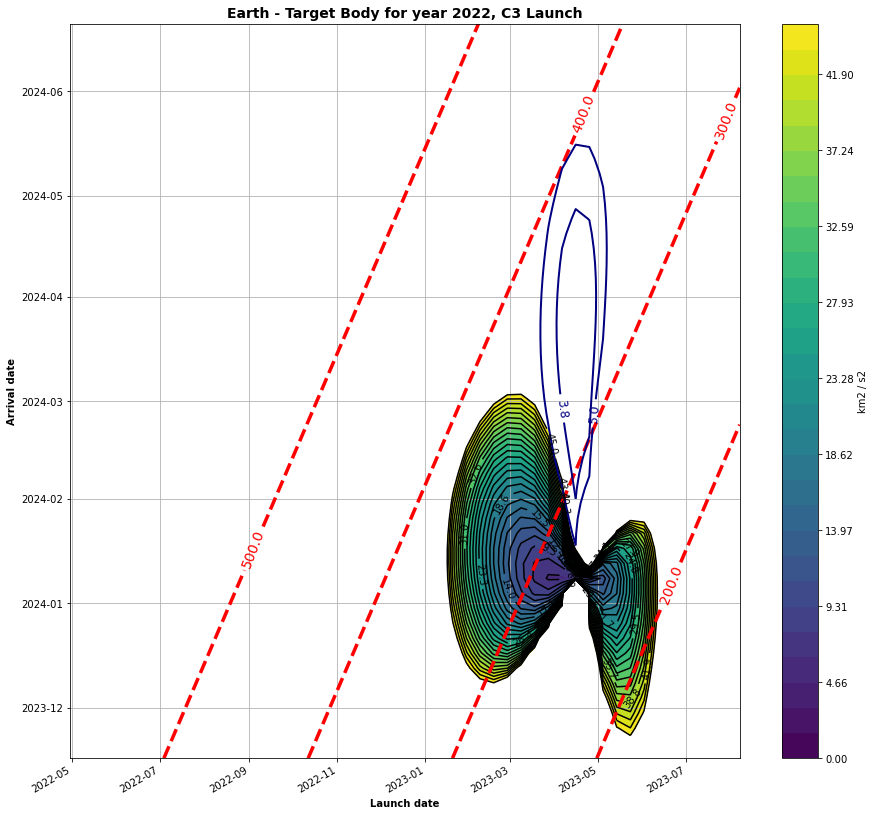

In [49]:
from poliastro.plotting.porkchop import porkchop
from poliastro.bodies import Earth
from poliastro.util import time_range

launch_span = time_range("2022-04-30", end="2023-08-07")
arrival_span = time_range("2023-11-16", end="2024-06-21")

eros = Orbit.from_sbdb("eros")

dv_launch, dev_dpt, c3dpt, c3arr, tof = porkchop(Earth, eros, launch_span, arrival_span)

# 4 база

In [48]:
# Геоцентрический участок траектории 

V_inf_geo = 7.6940987
R = r+200

V0 = sqrt (mu/(R))
e_geo = 1 + (R*V_inf_geo*V_inf_geo)/mu
p_geo = R*(1+e_geo)
a_geo = p_geo/(e_geo*e_geo-1)
n_geo = sqrt (mu/a_geo/a_geo/a_geo)
V_geo = sqrt ((2*mu)/R+V_inf_geo*V_inf_geo) 
dV = V_geo - V0

print (f"Скорость на круговой орбите {V0}")
print (f"Эксцентриситет {e_geo}")
print (f"Фокальный параметр {p_geo}")
print (f"Большая полуось {a_geo}")
print (f"Среднее движение {n_geo}")
print (f"Cкорость КА после импульса разгонного блока {V_geo}")
print (f"Импульс скорости, потребный для формирования гиперболической траектории {dV}")

Скорость на круговой орбите 7.788487982042219
Эксцентриситет 1.975908718921728
Фокальный параметр 19554.696192034673
Большая полуось 6733.211695516189
Среднее движение 0.001142708568798407
Cкорость КА после импульса разгонного блока 13.435782258513044
Импульс скорости, потребный для формирования гиперболической траектории 5.6472942764708245


# 1 доп

In [50]:
from astropy import units as u
from astropy.time import Time

from matplotlib import pyplot as plt

from poliastro.bodies import Sun, Earth, Mars
from poliastro.ephem import Ephem
from poliastro.maneuver import Maneuver
from poliastro.plotting.static import StaticOrbitPlotter
from poliastro.twobody import Orbit
from poliastro.util import time_range

In [59]:
EPOCH_DPT = Time("2018-12-01", scale="tdb")
EPOCH_ARR = EPOCH_DPT + 2 * u.year

epochs = time_range(EPOCH_DPT, end=EPOCH_ARR)

earth = Ephem.from_body(Earth, epochs=epochs)
eros = Ephem.from_horizons("Eros", epochs=epochs)

earth_departure = Orbit.from_ephem(Sun, earth, EPOCH_DPT)
eros_arrival = Orbit.from_ephem(Sun, eros, EPOCH_ARR)

In [60]:
def lambert_transfer(ss_dpt, ss_arr, revs):

    lambert_short = Maneuver.lambert(earth_departure, eros_arrival, short=True, M=revs)
    lambert_long = Maneuver.lambert(earth_departure, eros_arrival, short=False, M=revs)

    ss_short, _ = ss_dpt.apply_maneuver(lambert_short, intermediate=True)
    ss_long, _ = ss_dpt.apply_maneuver(lambert_long, intermediate=True)

    return ss_short, ss_long

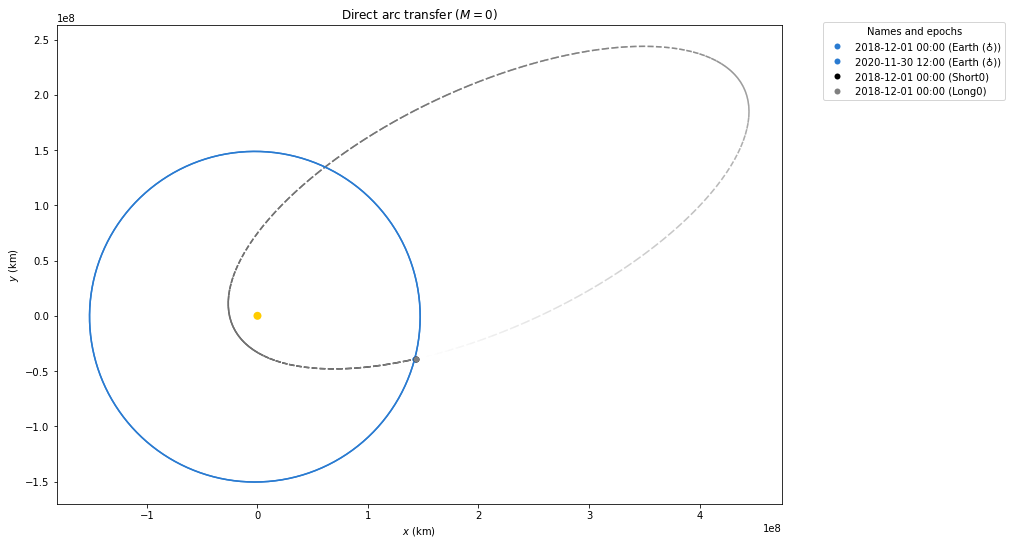

In [78]:
# M = 0

ss_short0, ss_long0 = lambert_transfer(earth_departure, eros_arrival, revs=0)

fig, ax = plt.subplots(figsize=(5,10))
op = StaticOrbitPlotter(ax=ax)
ax.set_title("Direct arc transfer ($M=0$)")

orbit_set = {ss_short0: ["Short0", "black"],
            ss_long0: ["Long0", "grey"]}

op.plot_body_orbit(Earth, EPOCH_DPT)
op.plot_body_orbit(Earth, EPOCH_ARR)

for ss in orbit_set:
    op.plot(ss, label=orbit_set[ss][0], color=orbit_set[ss][-1], trail=True)

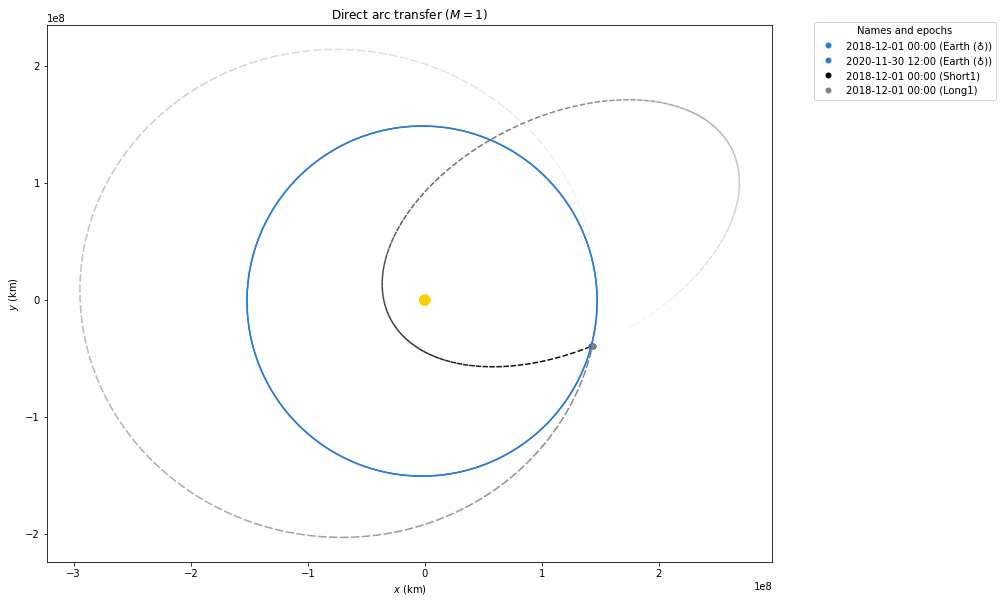

In [79]:
# M=1
ss_short1, ss_long1 = lambert_transfer(earth_departure, mars_arrival, revs=1)

fig, ax = plt.subplots(figsize=(5,10))
op = StaticOrbitPlotter(ax=ax)
ax.set_title("Direct arc transfer ($M=1$)")

orbit_set = {ss_short1: ["Short1", "black"],
            ss_long1: ["Long1", "grey"]}

op.plot_body_orbit(Earth, EPOCH_DPT)
op.plot_body_orbit(Earth, EPOCH_ARR)

for ss in orbit_set:
    op.plot(ss, label=orbit_set[ss][0], color=orbit_set[ss][-1], trail=True)

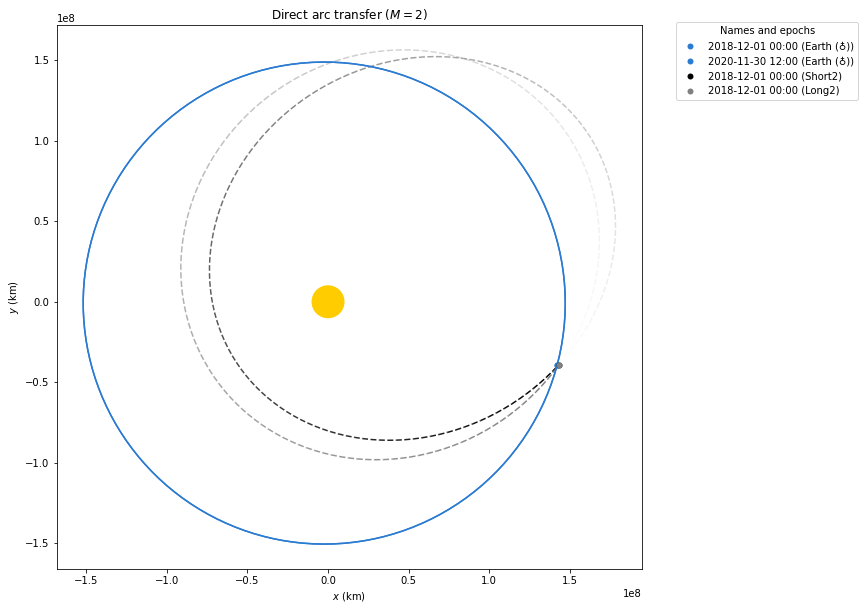

In [80]:
# M=2 
ss_short2, ss_long2 = lambert_transfer(earth_departure, eros_arrival, revs=2)

fig, ax = plt.subplots(figsize=(5,10))
op = StaticOrbitPlotter(ax=ax)
ax.set_title("Direct arc transfer ($M=2$)")

orbit_set = {ss_short2: ["Short2", "black"],
            ss_long2: ["Long2", "grey"]}

op.plot_body_orbit(Earth, EPOCH_DPT)
op.plot_body_orbit(Earth, EPOCH_ARR)

for ss in orbit_set:
    op.plot(ss, label=orbit_set[ss][0], color=orbit_set[ss][-1], trail=True)

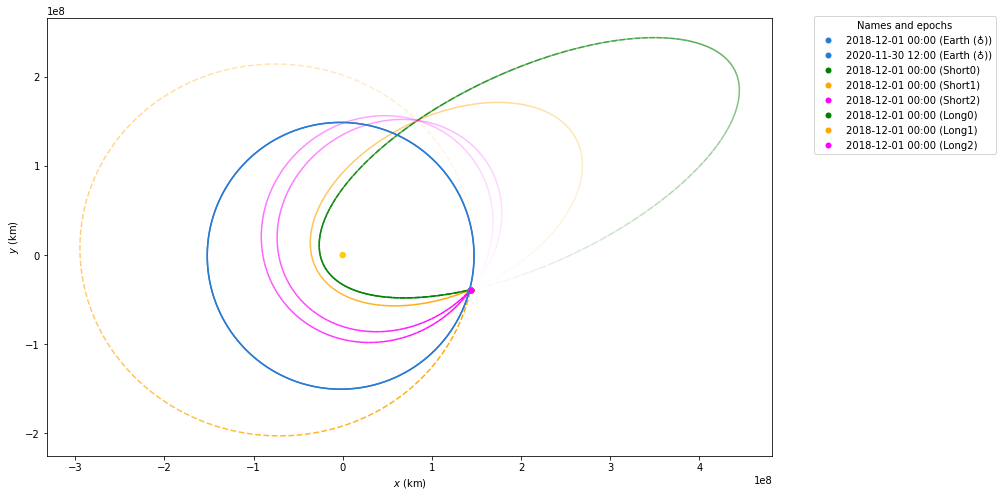

In [82]:
fig, ax = plt.subplots(figsize=(5,10))
op = StaticOrbitPlotter(ax=ax)
ss_lines = []

orbit_set = {ss_short0: ["Short0", "green", "-."],
            ss_short1: ["Short1", "orange", "-."],
            ss_short2: ["Short2", "magenta", "-."],
            ss_long0: ["Long0", "green", "--"],
            ss_long1: ["Long1", "orange", "--"],
            ss_long2: ["Long2", "magenta", "--"],
            }

op.plot_body_orbit(Earth, EPOCH_DPT)
op.plot_body_orbit(Earth, EPOCH_ARR)

for ss in orbit_set:
    lines = op.plot(ss, label=orbit_set[ss][0], color=orbit_set[ss][1], trail=True)
    lines[0].set_linestyle(orbit_set[ss][-1])